In [1]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/runburg/github/agn_lf


In [2]:
xservs_catalog = table.Table.read('./data/tableA.v01.fits')
# xservs_catalog.columns
print(len(xservs_catalog))
xservs_catalog[0]

5242


XID,RA,DEC,XPOSERR,R68,R99,EMLERR,SB_RA,SB_DEC,HB_RA,HB_DEC,FB_RA,FB_DEC,SB_DET_ML,HB_DET_ML,FB_DET_ML,SB_RELIABILITY,HB_RELIABILITY,FB_RELIABILITY,SB_EXP,HB_EXP,FB_EXP,SB_EXPPN,SB_EXPM1,SB_EXPM2,HB_EXPPN,HB_EXPM1,HB_EXPM2,FB_EXPPN,FB_EXPM1,FB_EXPM2,SB_BKG,HB_BKG,FB_BKG,SB_BKGPN,SB_BKGM1,SB_BKGM2,HB_BKGPN,HB_BKGM1,HB_BKGM2,FB_BKGPN,FB_BKGM1,FB_BKGM2,SB_SCTS,HB_SCTS,FB_SCTS,SB_SCTPN,SB_SCTM1,SB_SCTM2,HB_SCTPN,HB_SCTM1,HB_SCTM2,FB_SCTPN,FB_SCTM1,FB_SCTM2,SB_SCTS_ERR,HB_SCTS_ERR,FB_SCTS_ERR,SB_SCTPN_ERR,SB_SCTM1_ERR,SB_SCTM2_ERR,HB_SCTPN_ERR,HB_SCTM1_ERR,HB_SCTM2_ERR,FB_SCTPN_ERR,FB_SCTM1_ERR,FB_SCTM2_ERR,SB_RATE,SB_RATEPN,SB_RATEM1,SB_RATEM2,HB_RATE,HB_RATEPN,HB_RATEM1,HB_RATEM2,FB_RATE,FB_RATEPN,FB_RATEM1,FB_RATEM2,SB_RATE_ERR,SB_RATEPN_ERR,SB_RATEM1_ERR,SB_RATEM2_ERR,HB_RATE_ERR,HB_RATEPN_ERR,HB_RATEM1_ERR,HB_RATEM2_ERR,FB_RATE_ERR,FB_RATEPN_ERR,FB_RATEM1_ERR,FB_RATEM2_ERR,SB_FLUX,SB_FLUXERR,HB_FLUX,HB_FLUXERR,FB_FLUX,FB_FLUXERR,HR,HR_LERR,HR_UERR,BEHR_PN,BEHR_LB_PN,BEHR_UB_PN,BEHR_M1,BEHR_LB_M1,BEHR_UB_M1,BEHR_M2,BEHR_LB_M2,BEHR_UB_M2,LX,CSCID,XXLID,NALL_SERVS,NALL_VIDEO,NALL_CFHT,NALL_HSC,NMATCH_LR_SERVS,NMATCH_LR_VIDEO,NMATCH_LR_CFHT,NMATCH_LR_HSC,LR_RELIABLE,SERVS_BLENDING,CATALOG,OIR_RA,OIR_DEC,XOIR_SEP,LR,SERVS_RA,SERVS_DEC,SERVS_ID,SERVS_MR,VIDEO_RA,VIDEO_DEC,VIDEO_ID,VIDEO_MR,CFHT_RA,CFHT_DEC,CFHT_ID,CFHT_MR,HSC_RA,HSC_DEC,HSC_ID,HSC_MR,SERVS_MAG1,SERVS_MAG2,SERVS_MAG1_ERR,SERVS_MAG2_ERR,SWIRE_MAG1,SWIRE_MAG2,SWIRE_MAG3,SWIRE_MAG4,SWIRE_MAG1_ERR,SWIRE_MAG2_ERR,SWIRE_MAG3_ERR,SWIRE_MAG4_ERR,SWIRE_MIPS24,SWIRE_MIPS24_ERR,VIDEO_ZMAG,VIDEO_ZMAGERR,VIDEO_YMAG,VIDEO_YMAGERR,VIDEO_JMAG,VIDEO_JMAGERR,VIDEO_HMAG,VIDEO_HMAGERR,VIDEO_KSMAG,VIDEO_KSMAGERR,CFHT_UMAG,CFHT_UMAGERR,CFHT_GMAG,CFHT_GMAGERR,CFHT_RMAG,CFHT_RMAGERR,CFHT_IMAG,CFHT_IMAGERR,CFHT_ZMAG,CFHT_ZMAGERR,HSC_GMAG,HSC_GMAGERR,HSC_RMAG,HSC_RMAGERR,HSC_IMAG,HSC_IMAGERR,HSC_ZMAG,HSC_ZMAGERR,HSC_YMAG,HSC_YMAGERR,ZSPEC_RA,ZSPEC_DEC,ZSPEC_ID,ZSPEC,ZSOURCE,ZOFLAG,ZPHOT,ZPHOT_UERR,ZPHOT_LERR,ZPHOT_QZ,CLASS,SECONDARY_CATALOG,SECONDARY_RA,SECONDARY_DEC,SECONDARY_SEP,SECONDARY_LR,SECONDARY_SERVS_RA,SECONDARY_SERVS_DEC,SECONDARY_SERVS_ID,SECONDARY_SERVS_MR,SECONDARY_VIDEO_RA,SECONDARY_VIDEO_DEC,SECONDARY_VIDEO_ID,SECONDARY_VIDEO_MR,SECONDARY_CFHT_RA,SECONDARY_CFHT_DEC,SECONDARY_CFHT_ID,SECONDARY_CFHT_MR,SECONDARY_HSC_RA,SECONDARY_HSC_DEC,SECONDARY_HSC_ID,SECONDARY_HSC_MR,SECONDARY_SERVS_MAG1,SECONDARY_SERVS_MAG2,SECONDARY_SERVS_MAG1_ERR,SECONDARY_SERVS_MAG2_ERR,SECONDARY_SWIRE_MAG1,SECONDARY_SWIRE_MAG2,SECONDARY_SWIRE_MAG3,SECONDARY_SWIRE_MAG4,SECONDARY_SWIRE_MAG1_ERR,SECONDARY_SWIRE_MAG2_ERR,SECONDARY_SWIRE_MAG3_ERR,SECONDARY_SWIRE_MAG4_ERR,SECONDARY_SWIRE_MIPS24,SECONDARY_SWIRE_MIPS24_ERR,SECONDARY_VIDEO_ZMAG,SECONDARY_VIDEO_ZMAGERR,SECONDARY_VIDEO_YMAG,SECONDARY_VIDEO_YMAGERR,SECONDARY_VIDEO_JMAG,SECONDARY_VIDEO_JMAGERR,SECONDARY_VIDEO_HMAG,SECONDARY_VIDEO_HMAGERR,SECONDARY_VIDEO_KSMAG,SECONDARY_VIDEO_KSMAGERR,SECONDARY_CFHT_UMAG,SECONDARY_CFHT_UMAGERR,SECONDARY_CFHT_GMAG,SECONDARY_CFHT_GMAGERR,SECONDARY_CFHT_RMAG,SECONDARY_CFHT_RMAGERR,SECONDARY_CFHT_IMAG,SECONDARY_CFHT_IMAGERR,SECONDARY_CFHT_ZMAG,SECONDARY_CFHT_ZMAGERR,SECONDARY_HSC_GMAG,SECONDARY_HSC_GMAGERR,SECONDARY_HSC_RMAG,SECONDARY_HSC_RMAGERR,SECONDARY_HSC_IMAG,SECONDARY_HSC_IMAGERR,SECONDARY_HSC_ZMAG,SECONDARY_HSC_ZMAGERR,SECONDARY_HSC_YMAG,SECONDARY_HSC_YMAGERR,SECONDARY_ZSPEC_RA,SECONDARY_ZSPEC_DEC,SECONDARY_ZSPEC_ID,SECONDARY_ZSPEC,SECONDARY_ZSOURCE,SECONDARY_ZOFLAG,TERTIARY_CATALOG,TERTIARY_RA,TERTIARY_DEC,TERTIARY_SEP,TERTIARY_LR,TERTIARY_SERVS_RA,TERTIARY_SERVS_DEC,TERTIARY_SERVS_ID,TERTIARY_SERVS_MR,TERTIARY_VIDEO_RA,TERTIARY_VIDEO_DEC,TERTIARY_VIDEO_ID,TERTIARY_VIDEO_MR,TERTIARY_CFHT_RA,TERTIARY_CFHT_DEC,TERTIARY_CFHT_ID,TERTIARY_CFHT_MR,TERTIARY_HSC_RA,TERTIARY_HSC_DEC,TERTIARY_HSC_ID,TERTIARY_HSC_MR,TERTIARY_SERVS_MAG1,TERTIARY_SERVS_MAG2,TERTIARY_SERVS_MAG1_ERR,TERTIARY_SERVS_MAG2_ERR,TERTIARY_SWIRE_MAG1,TERTIARY_SWIRE_MAG2,TERTIARY_SWIRE_MAG3,TERTIARY_SWIRE_MAG4,TERTIARY_SWIRE_MAG1_ERR,TERTIARY_SWIRE_MAG2

In [3]:
# xservs_catalog.columns[109]
# str(xservs_catalog['CLASS'][10])[1]
xservs_catalog['ZPHOT', 'ZPHOT_UERR', 'ZPHOT_LERR', 'ZSPEC']

ZPHOT,ZPHOT_UERR,ZPHOT_LERR,ZSPEC
float64,float64,float64,float64
-99.0,-99.0,-99.0,-99.0
-99.0,-99.0,-99.0,1.8205
0.431,0.485,0.217,0.4587000012397766
-99.0,-99.0,-99.0,0.95920330286026
-99.0,-99.0,-99.0,0.4103716
-99.0,-99.0,-99.0,1.9319000244140625
1.4,1.6840000000000002,1.047,-99.0
1.815,1.995,1.449,-99.0
0.308,0.37799999999999995,0.16899999999999998,0.2941402


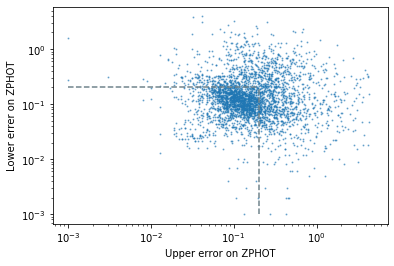

In [4]:
fig, axs = plt.subplots()
zphots = xservs_catalog['ZPHOT']
has_zphot = zphots > 0
plt.plot(xservs_catalog['ZPHOT_UERR'][has_zphot]-zphots[has_zphot], zphots[has_zphot] - xservs_catalog['ZPHOT_LERR'][has_zphot], marker='o', ms=1, ls='', alpha=0.5)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel('Upper error on ZPHOT')
axs.set_ylabel('Lower errer on ZPHOT')
line = np.logspace(-3, np.log10(0.2))
axs.plot(line, len(line)*[0.2], '--', color='xkcd:steel gray')
axs.plot(len(line)*[0.2], line, '--', color='xkcd:steel gray')
np.mean(xservs_catalog['ZPHOT_UERR'][has_zphot]-zphots[has_zphot]), np.mean(zphots[has_zphot] - xservs_catalog['ZPHOT_LERR'][has_zphot])
robust_z_values = (xservs_catalog['ZPHOT_UERR'][has_zphot]-zphots[has_zphot] < 0.2) & (zphots[has_zphot] - xservs_catalog['ZPHOT_LERR'][has_zphot] < 0.2)
# xservs_catalog = xservs_catalog[robust_z_values]

In [5]:
lum_selected_agn = [str(selection)[1] == '2' for selection in xservs_catalog['CLASS']]
print(np.sum(lum_selected_agn))

1625


In [6]:
cosmo = af.setup_cosmology()
print(len(xservs_catalog))

xservs_catalog = xservs_catalog[(xservs_catalog['ZPHOT'] > 0 ) | (xservs_catalog['ZSPEC'] > 0)]
print(len(xservs_catalog))

import astropy.units as u

z = np.array([row['ZSPEC'] if row['ZSPEC'] > 0 else row['ZPHOT'] for row in xservs_catalog])
l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * xservs_catalog['FB_FLUX']

5242
4505


In [7]:
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42
l_sample_max = 3e45

good_redshift_and_l_selected = (l_sample_min < l) & (l_sample_max > l) & (z_sample_min < z) & (z_sample_max > z)
l = l[good_redshift_and_l_selected]
z = z[good_redshift_and_l_selected]
print(len(z))

3786


[0.48861861 0.61877899 0.78361206 0.9923541  1.25670175 1.5914675
 2.01540963 2.55228333 3.2321718  4.09317197]


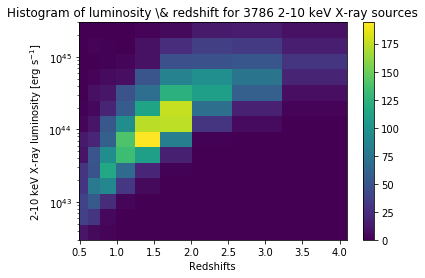

In [8]:
num_bins_z = 10
num_bins_l = 15
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min)-0.01, np.log10(z_sample_max)+0.01, num=num_bins_z)
print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

# print(len(z))
fig, ax = vmax.l_z_histo(l, z, l_bins, z_bins, band='2-10 keV X-ray', unit=r'erg s$^{-1}$')

In [26]:
flux_limit = 6.5e-15
zmax = vmax.compute_zmax(l, z, cosmo, flux_limit, zspacing=0.01)
zmin = np.array([0]*len(zmax))

full_fluxes = xservs_catalog['FB_FLUX']
# print(full_fluxes)
coverage_correction = vmax.coverage_correction(full_fluxes, full_fluxes[good_redshift_and_l_selected])

image_file = './data/chen2018-xmmlss-data-products-2018-06-08/xexp_merged.full.v01.fits'
wcs, hdu = utils.load_wcs(image_file)
cov_function = vmax.coverage_function(hdu.data, wcs, 3824, 2694, detector_area=36, photon_energy=7e-9)

def cov_func(l, z):
    
    flux = l / (4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2)
#     print(flux[0, 0], cov_function(flux[0, 0]))
    return coverage_correction(flux) * cov_function(flux)

vmax_vals = vmax.compute_binned_vmax_values(l, (z, zmin, zmax), l_bins, z_bins, cosmo, bin_z_bounds=False, coverage=cov_func)

       FB_FLUX        
----------------------
 7.934399176641099e-15
 5.306224840210435e-15
5.3165615873221796e-15
 2.666358521789005e-14
1.3011202239769742e-14
 2.942323361151079e-15
 4.714508837551009e-15
 1.213756946505811e-14
 6.802067018631819e-15
  5.69986694172747e-15
                   ...
1.1313959263253097e-14
 7.674448956368787e-15
 6.911673886365573e-14
 9.694527692322477e-15
 3.439416787109356e-14
4.4911004337967364e-14
1.4773479884609066e-13
 8.046107797489395e-15
 9.584737566124027e-15
3.0413518539784137e-14
 7.085698547000078e-15
Length = 4505 rows


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 35.5  -4.8  
CRPIX : 1969.0  1267.0  
CD1_1 CD1_2  : -0.001111111111111  0.0  
CD2_1 CD2_2  : 0.0  0.001111111111111  
NAXIS : 3824  2694


/Users/runburg/github/agn_lf/source/vmax.py:155: RuntimeWarning: divide by zero encountered in true_divide
  fluxes = 1/(data[:-1, :-1]).flatten()


[6 3 6 ... 5 1 5]


In [10]:
import importlib
importlib.reload(vmax)
lit_data = {}
l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()
lf_vals, lf_errs = vmax.compute_lf_values(l, z, vmax_vals, z_bins, l_bins)

In [11]:
aird_lade_params_central = {'A': 10**-4.53, 
                               'gamma1':0.62, 
                               'gamma2':3.01,
                               'Lstar': 10**44.77,
                               'zc':0.75,
                               'p1':6.36,
                               'p2':-0.24,
                               'd':-0.19
                              }
aird_lade_params_min = {'A': 10**-4.46, 
                               'gamma1':0.6, 
                               'gamma2':2.9,
                               'Lstar': 10**44.71,
                               'zc':0.66,
                               'p1':5.96,
                               'p2':-0.51,
                               'd':-.21
                              }
aird_lade_params_max = {'A': 10**-4.6, 
                               'gamma1':0.64, 
                               'gamma2':3.12,
                               'Lstar':10**44.83,
                               'zc':0.84,
                               'p1':6.76,
                               'p2':0.03,
                               'd':-0.17
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(43, 45.2, num=50)
aird_mid = utils.LADE(ls, center_zbins, **aird_lade_params_central, no_k=True)
aird_high = utils.LADE(ls, center_zbins, **aird_lade_params_max, no_k=True)
aird_low = utils.LADE(ls, center_zbins, **aird_lade_params_min, no_k=True)
# print(ranalli_mid[0])
lit_data['Aird LADE'] = list(zip(aird_mid, aird_high, aird_low))
# np.array(lit_data['Ranalli LADE'])[0], np.array(lit_data['Aird 2010'])[0]

In [24]:
importlib.reload(utils)
importlib.reload(vmax)
ranalli_lade_params_central = {'A': 10**-3.53, 
                               'gamma1':0.16, 
                               'gamma2':2.48,
                               'Lstar': 10**42.72,
                               'zc':1.72,
                               'p1':4.67,
                               'p2':-0.3,
                               'd':-0.29
                              }
ranalli_lade_params_min = {'A': 10**-3.65, 
                               'gamma1':0.09, 
                               'gamma2':2.37,
                               'Lstar': 10**42.65,
                               'zc':1.53,
                               'p1':4.35,
                               'p2':-0.91,
                               'd':-0.31
                              }
ranalli_lade_params_max = {'A': 10**-3.48, 
                               'gamma1':0.23, 
                               'gamma2':2.6,
                               'Lstar':10**42.82,
                               'zc':1.93,
                               'p1':5.0,
                               'p2':0.02,
                               'd':-0.26
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(43, 45.2, num=50)
ranalli_mid = af.LADE(ls, center_zbins, **ranalli_lade_params_central)
ranalli_high = af.LADE(ls, center_zbins, **ranalli_lade_params_max)
ranalli_low = af.LADE(ls, center_zbins, **ranalli_lade_params_min)
# print(ranalli_mid[0])
lit_data['Ranalli LADE'] = list(zip(ranalli_mid, ranalli_high, ranalli_low))
# np.array(lit_data['Ranalli LADE'])[0], np.array(lit_data['Aird 2010'])[0]

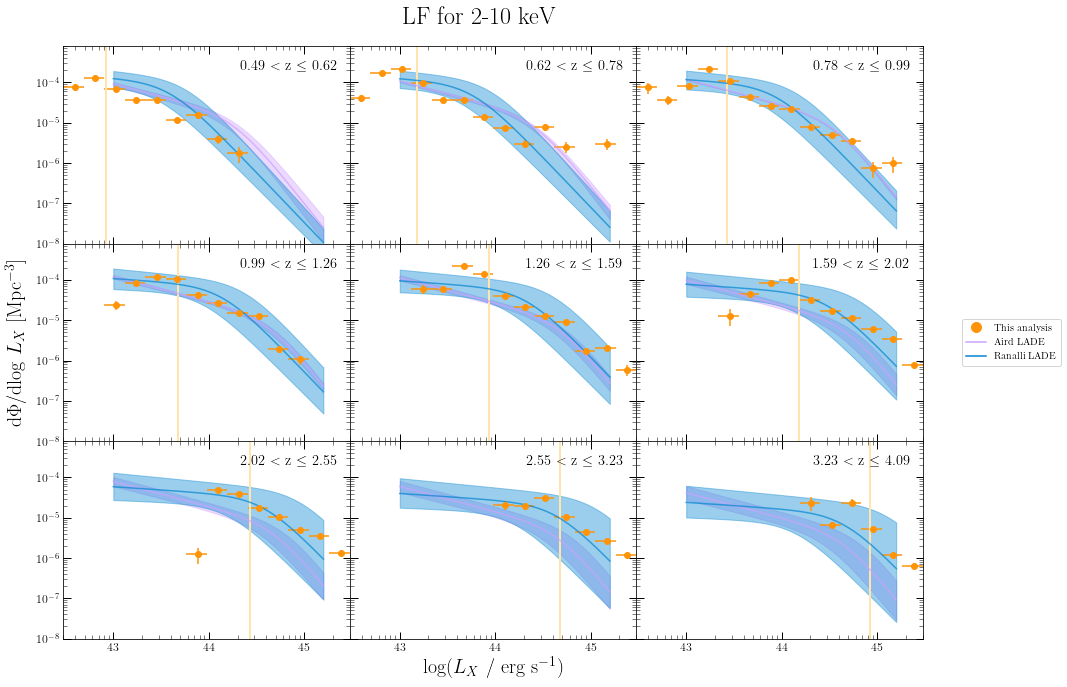

In [25]:
fig, axs, big_ax = vmax.plot_lf_vmax(lf_vals, lf_errs, z_bins, l_bins, \
                                     compare_to_others=lit_data, \
                                     lum_limits=l_limits, title='LF for 2-10 keV', \
                                     outfile='./output/xray_lf.png', lum_sublabel='_X')

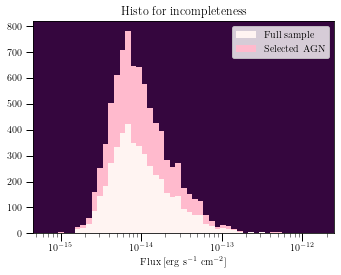

In [14]:
full_fluxes = xservs_catalog['FB_FLUX']
flux_bins = np.logspace(np.log10(min(full_fluxes)), np.log10(max(full_fluxes)), num=50)
fig, ax = vmax.incompleteness_histo(full_fluxes, full_fluxes[good_redshift_and_l_selected], flux_bins=flux_bins)
fig.savefig('./output/incompleteness_histo.png')

In [15]:
image_file = './data/chen2018-xmmlss-data-products-2018-06-08/xexp_merged.full.v01.fits'
importlib.reload(vmax)
importlib.reload(utils)
wcs, hdu = utils.load_wcs(image_file)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 35.5  -4.8  
CRPIX : 1969.0  1267.0  
CD1_1 CD1_2  : -0.001111111111111  0.0  
CD2_1 CD2_2  : 0.0  0.001111111111111  
NAXIS : 3824  2694


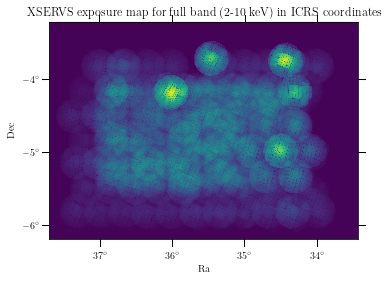

In [16]:
fig, ax = vmax.exposure_plot(wcs, hdu.data, survey='XSERVS', band='full band (2-10 keV)')

/Users/runburg/github/agn_lf/source/vmax.py:155: RuntimeWarning: divide by zero encountered in true_divide
  fluxes = 1/(data[:-1, :-1]).flatten()


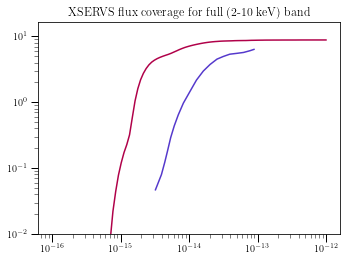

In [17]:
cov_func = vmax.coverage_function(hdu.data, wcs, 3824, 2694, detector_area=36, photon_energy=7e-9)

ranalli = np.array([[3.234579048402373e-15, 0.046800590726239225],
[3.954492818470057e-15, 0.07962852110271917],
[4.420434711413654e-15, 0.1222991869375129],
[4.856893998989995e-15, 0.18236122222601137],
[5.401461929123689e-15, 0.2908177200919355],
[6.0772268433984334e-15, 0.4357861819497073],
[6.9654850088075764e-15, 0.6424362077190431],
[8.267663307570593e-15, 0.968755801543341],
[1.0366208408568655e-14, 1.4674725828384785],
[1.283839402032368e-14, 2.1666799548490068],
[1.6171488639386294e-14, 2.9727838264231394],
[2.0299866912836456e-14, 3.7432403328810975],
[2.5614185166910568e-14, 4.511438707073378],
[3.171314400418349e-14, 4.953004620220058],
[3.9399813258449504e-14, 5.35993326131349],
[4.965985908263762e-14, 5.5164721661153155],
[6.247029270720968e-14, 5.692346186763688],
[7.756817736170046e-14, 6.049718652378999],
[8.883331632396991e-14, 6.338872460062676
]])

fig, ax = vmax.cov_func_plot(cov_func, -16, -12, survey='XSERVS', band='full (2-10 keV)', comparison_data=(('Ranalli', ranalli),))

In [18]:
ax.plot(ranalli[:, 0], ranalli[:, 1], label="Ranalli [arb. shift]", color='xkcd:blurple')
ax.legend(loc='lower right')
ax.set_xlabel('Flux [photons/area/s]')
ax.set_ylabel(r'Coverage [deg$^2$]')
fig
for item in (('hi', ranalli),):
    print(len(item))

2


In [19]:
fig.savefig('./output/coverage_plot.png')


In [20]:
import scipy.stats

[ 90000.  90001.  90002. ... 299997. 299998. 299999.] [2.25486132e-228 2.50537363e-228 2.78368662e-228 ... 0.00000000e+000
 0.00000000e+000 0.00000000e+000]


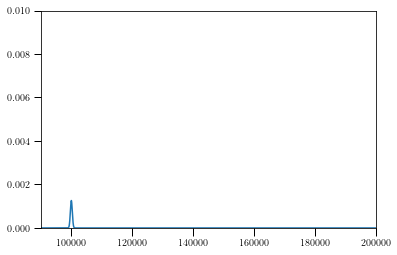

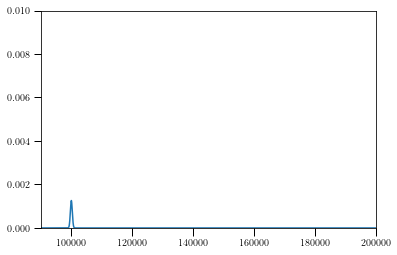

In [21]:
fig, axs = plt.subplots()
vals = np.arange(9e4,3e5)
pdf = scipy.stats.poisson.pmf(vals, 1e5)
print(vals, pdf)
axs.plot(vals, pdf)
axs.set_xlim(left=9e4, right=2e5)
# axs.set_yscale('linear')
axs.set_ylim(bottom=0, top=.01)
fig

In [22]:
zero_bin = np.array([(0,0)]*num_bins_l)
ranalli75 = np.array([[1.8204781835615654e+42, 0.00004688702004672812],
[5.768251354223323e+42, 0.00012551169959105474],
[1.8224728420637193e+43, 0.0000808899816399594],
[5.67651928907583e+43, 0.00004281332398719396],
[1.7906555296923534e+44, 0.000012551169959105474],
[5.640716651800656e+44, 0.0000018329807108324375],
[1.7787122083815078e+45, 4.4803896929336637e-7],
[5.601901226975743e+45, 5.884869574824701e-8]])
ranalli125 = np.array([[5.5435860594493034e+42, 0.000011753985687895042],
[1.7223596240621015e+43, 0.00005627622162420234],
[5.448405638807658e+43, 0.00004791131283650859],
[1.7259405451530703e+44, 0.000020766691479308065],
[5.556837965273878e+44, 0.000003736408486470932],
[1.7386035802007045e+45, 6.215740165584362e-7],
[5.609887898604562e+45, 3.906235874255027e-8
]])
ranalli175 = np.array([[1.7879934792230063e+43, 0.000015551805709238664],
[5.716073332551424e+43, 0.00004473886184925997],
[1.801028165980116e+44, 0.000026170270956732876],
[5.7577441922252836e+44, 0.000008146271948214161],
[1.787993479222977e+45, 8.146271948214161e-7]])
ranalli250 = np.array([[5.424154918951895e+43, 0.00001601379932965642],
[1.7134066660943036e+44, 0.00002714612628809034],
[5.432130267357807e+44, 0.00000784119081413017],
[1.725103245577943e+45, 9.948390153580107e-7
]])
ranalli350 = np.array([[5.516216936863732e+43, 0.0000073015881038410896],
[1.7627901206921975e+44, 0.000009293287013925729],
[5.793192144773722e+44, 0.000004437724247661295],
[1.7751707021476756e+45, 2.9840845599069994e-7
]])
# lit_data={'Ranalli 2016':[ranalli75, ranalli75, ranalli75, ranalli125, ranalli125, ranalli175, ranalli250, ranalli250, ranalli350]}

In [23]:
aird5 = np.array([[2.033624084686662e+41, 0.0004650924258972792],
[4.832930238571732e+41, 0.0003181396515358571],
[1.1485512424239157e+42, 0.00020988892770326998],
[2.7772119324293323e+42, 0.0001849335501313507],
[6.600075022827048e+42, 0.00006137028147523471],
[1.541593692842248e+43, 0.00003976275248399674],
[3.6636145440206636e+43, 0.00002353573408996959],
[8.85866790410065e+43, 0.000004969756135303314],
[2.105272272765668e+44, 0.0000019059201959126445],
[5.003202953825917e+44, 2.297505419511507e-7],
[1.1686088553466402e+45, 1.1556523988776559e-7
]])
aird6 = np.array([[2.0549813357409736e+41, 0.0016076280197404778],
[4.893900918477419e+41, 0.001106151042531592],
[1.1074776624451061e+42, 0.00042294964015028575],
[2.775554463314989e+42, 0.00030698234695950466],
[6.498421570076656e+42, 0.0001864741158671012],
[6.498421570076656e+42, 0.0001864741158671012],
[1.5475873545578656e+43, 0.00009823540528533097],
[3.685551320671243e+43, 0.00004105840382532986],
[8.777073873921625e+43, 0.0000062203444311790165],
[2.126112333899638e+44, 0.000005491496632886971],
[4.8939009184774186e+44, 9.593095388678326e-7],
[1.165473660676274e+45, 8.672500426996944e-8
]])
aird8 = np.array([[1.1783152148394137e+42, 0.0009369253689310116],
[2.7746838332769845e+42, 0.00029650531783107816],
[6.772285498714152e+42, 0.00022696133040863876],
[1.5446158257255e+43, 0.00014821522821837686],
[3.70382905944931e+43, 0.00007968548021212688],
[9.022576566049425e+43, 0.000027544328386614646],
[2.12792484345009e+44, 0.000016465418994218013],
[5.008008140019909e+44, 0.000004141490330951619],
[1.1749183117831125e+45, 2.86841317712791e-7],
[2.8035271989546578e+45, 2.058037222352539e-8
]])
aird10 = np.array([[1.1333269171297019e+42, 0.00039810717055349936],
[2.6434551458924697e+42, 0.00033944485527694036],
[6.495226024243585e+42, 0.00017316556668620905],
[1.5410634236889313e+43, 0.0001400083205615401],
[3.538289498751096e+43, 0.00007399983804321452],
[8.542029874459734e+43, 0.00005011872336272735],
[2.0303886897216604e+44, 0.000019258186341850842],
[1.1318518701355524e+45, 6.772815277441427e-7],
[2.7444892780963372e+45, 7.666822074546222e-8
]])
aird12 = np.array([[2.6176431902199304e+42, 0.00021308508748061854],
[6.396908655341961e+42, 0.00008230683000823993],
[1.5632550875412025e+43, 0.00006904517189119679],
[3.8202303649946607e+43, 0.000056885012344750115],
[8.56713914996759e+43, 0.000028785865995513617],
[1.9884169780083154e+44, 0.00002015722986549392],
[4.943446640476108e+44, 0.0000015639566064715666],
[1.1672507969054455e+45, 0.0000013599094625740439],
[6.620572143707537e+45, 1.1527308442089969e-8
]])
aird15 = np.array([[6.599517656509027e+42, 0.000051561608146754346],
[1.5584143078691544e+43, 0.00003378064342984338],
[3.742576891418273e+43, 0.00003210455127221931],
[8.690092320062009e+43, 0.000028930160581617874],
[2.017799679797168e+44, 0.000011958412935968476],
[4.845804106769178e+44, 0.0000041410520965573],
[1.1251735441780527e+45, 0.0000012225863699109943],
[2.7021367065307643e+45, 5.329871001276772e-7],
[6.380842850117492e+45, 1.4402662261974964e-8
]])
aird20 = np.array([[3.6067207952730063e+43, 0.000030351385686916772],
[8.570349978994005e+43, 0.000013203131390722677],
[2.0324276585584765e+44, 0.000012999567867950998],
[4.829278235207719e+44, 0.000005756246335532061],
[1.1314232445611516e+45, 8.036162975433914e-7
]])
aird25 = np.array([[1.5630809481906333e+43, 0.000044695012940806844],
[3.7015060883266337e+43, 0.000014218367688294832],
[8.969496495595183e+43, 0.000015273473785035314],
[2.1635493138709064e+44, 0.00000646965063314045],
[5.06285176308105e+44, 0.000005810970954396663],
[1.1545317501168417e+45, 8.717952687673054e-7
]])
# lit_data['Aird 2010'] = [aird5, aird6, aird8, aird10, aird12, aird15, aird20, aird25, aird25]